### Insight Follow Ups

- Could we do what % of districts not meeting would reach 1 Mbps with a 100%, 200%, 300%, 400% increase, cumulative? 
- For example, if everyone went up 500%, what would happen? 

In [1]:
import numpy as np
import os
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
HOST_DAR = os.environ.get("HOST_DAR")
USER_DAR = os.environ.get("USER_DAR")
PASSWORD_DAR = os.environ.get("PASSWORD_DAR")
DB_DAR = os.environ.get("DB_DAR")
PORT_DAR = os.environ.get("PORT_DAR")
GITHUB = os.environ.get("GITHUB")

In [3]:
#open connection to DB
myConnection = psycopg2.connect( host=HOST_DAR, 
                                user=USER_DAR, 
                                password=PASSWORD_DAR, 
                                database=DB_DAR, 
                                port=PORT_DAR)

sql_query = """
select 
    d.district_id,
    d.funding_year,
    d.district_type,
    d.in_universe,
    dffa.fit_for_ia,
    d.num_students,
    dbw.ia_bw_mbps_total,
    dbw.projected_bw_fy2018,
    dbw.projected_bw_fy2018_cck12,
    dbw.meeting_2018_goal_oversub

-- basic district info
FROM ps.districts d

-- district costs and bw
JOIN ps.districts_bw_cost dbw
ON d.district_id = dbw.district_id
AND d.funding_year = dbw.funding_year

-- to check for fit for ia
JOIN ps.districts_fit_for_analysis dffa
ON d.district_id = dffa.district_id
AND d.funding_year = dffa.funding_year

where d.funding_year = 2019
"""

#query data
cur = myConnection.cursor()
cur.execute(sql_query)
names = [x[0] for x in cur.description]
rows = cur.fetchall()
df = pd.DataFrame(rows, columns=names)

In [4]:
df.head()

,district_id,funding_year,district_type,in_universe,fit_for_ia,num_students,ia_bw_mbps_total,projected_bw_fy2018,projected_bw_fy2018_cck12,meeting_2018_goal_oversub
0,881421,2019,Traditional,True,True,5687,2000,4833.95,5000,False
1,881422,2019,Traditional,True,True,194,1000,194,200,True
2,881423,2019,Traditional,True,True,1319,2000,1319,2000,True
3,881424,2019,Traditional,True,True,5387,1000,4578.95,5000,False
4,881427,2019,Traditional,True,True,13938,10000,9756.6,10000,True


### Masks/filters

In [5]:
mask_not_meeting = df.meeting_2018_goal_oversub == False
mask_meeting = df.meeting_2018_goal_oversub == True
mask_traditional = df.district_type == 'Traditional'
mask_fit_ia = df.fit_for_ia == True
mask_in_universe = df.in_universe == True

### Convert Decimal to Float

In [6]:
numeric_cols = ['num_students', 'ia_bw_mbps_total','projected_bw_fy2018']
df[numeric_cols] = df[numeric_cols].astype(float)

### Extrapolation

In [7]:
num_population_districts = df[mask_in_universe & mask_traditional].district_id.nunique()
num_sample_districts = df[mask_fit_ia &
                          mask_in_universe &
                          mask_traditional].district_id.nunique()

print(f"Number of population districts: {num_population_districts}")
print(f"Number of sample districts: {num_sample_districts}")

Number of population districts: 12912
Number of sample districts: 12653


In [8]:
# districts clean and not meeting 1 mbps
df_clean = df[mask_not_meeting & 
                mask_traditional & 
                mask_fit_ia & 
                mask_in_universe]

In [9]:
df_clean.shape

(7921, 10)

In [10]:
df_clean.district_id.nunique()

7921

### Calculating pct_bw_increase_to_meet_1Mbps

In [12]:
df_clean.loc[:, 'pct_bw_increase_to_meet_1Mbps'] = ((df_clean.loc[:, 'projected_bw_fy2018'] - df_clean.loc[: ,'ia_bw_mbps_total'])/df_clean.loc[:, 'ia_bw_mbps_total'])*100

In [13]:
df_clean.head()

,district_id,funding_year,district_type,in_universe,fit_for_ia,num_students,ia_bw_mbps_total,projected_bw_fy2018,projected_bw_fy2018_cck12,meeting_2018_goal_oversub,pct_bw_increase_to_meet_1Mbps
0,881421,2019,Traditional,True,True,5687.0,2000.0,4833.95,5000,False,141.697500
3,881424,2019,Traditional,True,True,5387.0,1000.0,4578.95,5000,False,357.895000
5,881428,2019,Traditional,True,True,2297.0,1000.0,2297.00,3000,False,129.700000
6,881431,2019,Traditional,True,True,10440.0,7500.0,8874.00,10000,False,18.320000
7,881433,2019,Traditional,True,True,3858.0,1650.0,3279.30,3000,False,98.745455


### Place `pct_bw_increase_to_meet_1Mbps` into bins for plotting

In [15]:
# indicate bins for categories
max_bin = 3100
increment = 100
bins = np.arange(0, max_bin, increment)

# create labels
labels = []
for i, b in enumerate(bins):
    if i == 0:
        labels.append("less than " + str(bins[i+1]) + '%')
    elif i < len(bins)-1:
        labels.append(str(bins[i])+'%')
    else:
        break

# add final category to labels
labels.append(str(max_bin-increment) +'% or over')

# categorize bw_pct_change
df_clean.loc[:,'bw_pct_change_category'] = pd.cut(df_clean['pct_bw_increase_to_meet_1Mbps'], 
                                                     bins=bins, 
                                                     labels=labels[:-1], right=False)

# add new category
df_clean.loc[:, 'bw_pct_change_category'] = df_clean['bw_pct_change_category'].cat.add_categories(str(max_bin-increment) + '% or over')

# fill in Nans (anything over max_bin)
df_clean[['bw_pct_change_category']] = df_clean[['bw_pct_change_category']].fillna(value=str(max_bin-increment) +'% or over')


# change index to string, and count values for plotting
df_clean.loc[:, 'bw_pct_change_category'] = df_clean['bw_pct_change_category'].astype(str)

In [17]:
df_clean[df_clean.bw_pct_change_category == '200%'].shape

(1089, 12)

In [18]:
df_clean.columns

Index(['district_id', 'funding_year', 'district_type', 'in_universe',
       'fit_for_ia', 'num_students', 'ia_bw_mbps_total', 'projected_bw_fy2018',
       'projected_bw_fy2018_cck12', 'meeting_2018_goal_oversub',
       'pct_bw_increase_to_meet_1Mbps', 'bw_pct_change_category'],
      dtype='object')

In [21]:
df_clean[(df_clean.pct_bw_increase_to_meet_1Mbps >= 200) & (df_clean.pct_bw_increase_to_meet_1Mbps < 300)].shape

(1089, 12)

In [24]:
# converting list to df for merging
df_temp = pd.DataFrame({'labels': labels})
df_temp.set_index('labels', inplace=True)

# count instances of category for district count
df_pct_change = df_clean.bw_pct_change_category.value_counts().to_frame()

# merge into resultant dataframe to keep order of index
df_pct_change = df_temp.merge(df_pct_change, left_index=True, right_index=True )
df_pct_change.reset_index(inplace=True)

# rename index column
df_pct_change.columns = ['pct_category', 'district_count']

# add extrapolated numbers
df_pct_change['district_count_extrapolated'] = (df_pct_change['district_count']*num_population_districts)/(num_sample_districts)

In [25]:
df_pct_change

,pct_category,district_count,district_count_extrapolated
0,less than 100%,3330,3398.163281
1,100%,1995,2035.836560
2,200%,1089,1111.291235
3,300%,639,652.079981
4,400%,347,354.102900
5,500%,213,217.359994
6,600%,118,120.415396
7,700%,76,77.555678
8,800%,43,43.880187
9,900%,16,16.327511


In [26]:
df_pct_change.district_count.sum()

7921

In [27]:
# cumulative sum (sample)
df_pct_change.loc[:, 'district_count_cumsum'] = df_pct_change['district_count'].cumsum(axis = 0) 

# cumulative sum (extrapolated)
df_pct_change.loc[:, 'district_count_extrapolated_cumsum'] = df_pct_change['district_count_extrapolated'].cumsum(axis = 0) 

# percentage by pct_category - cumulative(sample)
df_pct_change.loc[:, 'district_count_cumsum_pct'] = df_pct_change.loc[:, 'district_count_cumsum']/df_pct_change.district_count.sum()

# percentage by pct_category - cumulative(extrapolated)
df_pct_change.loc[:, 'district_count_extrapolated_cumsum_pct'] = df_pct_change.loc[:, 'district_count_extrapolated_cumsum']/df_pct_change.district_count_extrapolated.sum()

# percentage by pct_category (sample)
df_pct_change.loc[:, 'district_count_pct'] = df_pct_change.loc[:, 'district_count']/df_pct_change.district_count.sum()



In [28]:
df_pct_change

,pct_category,district_count,district_count_extrapolated,district_count_cumsum,district_count_extrapolated_cumsum,district_count_cumsum_pct,district_count_extrapolated_cumsum_pct,district_count_pct
0,less than 100%,3330,3398.163281,3330,3398.163281,0.420401,0.420401,0.420401
1,100%,1995,2035.836560,5325,5433.999842,0.672264,0.672264,0.251862
2,200%,1089,1111.291235,6414,6545.291077,0.809746,0.809746,0.137483
3,300%,639,652.079981,7053,7197.371058,0.890418,0.890418,0.080672
4,400%,347,354.102900,7400,7551.473959,0.934225,0.934225,0.043808
5,500%,213,217.359994,7613,7768.833952,0.961116,0.961116,0.026891
6,600%,118,120.415396,7731,7889.249348,0.976013,0.976013,0.014897
7,700%,76,77.555678,7807,7966.805026,0.985608,0.985608,0.009595
8,800%,43,43.880187,7850,8010.685213,0.991036,0.991036,0.005429
9,900%,16,16.327511,7866,8027.012724,0.993056,0.993056,0.002020


In [29]:
df_pct_change.district_count.sum()

7921

### Plotting cumulative districts/pct by pct_bw_increase

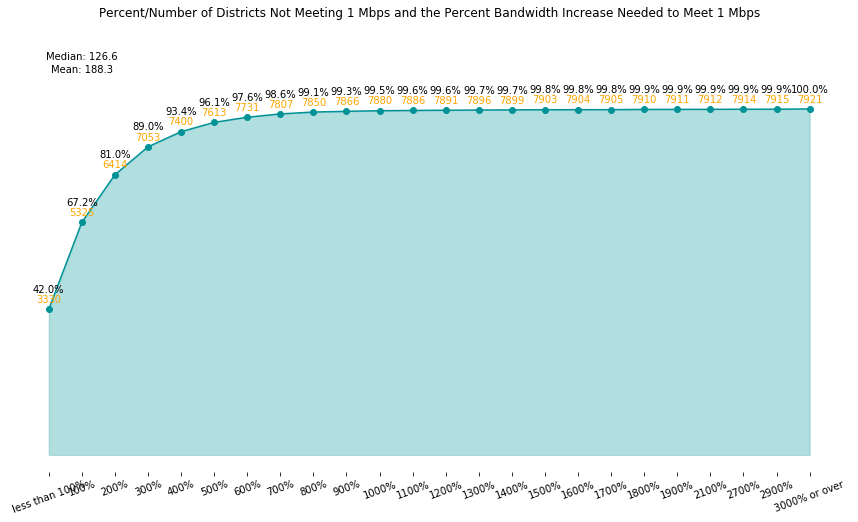

In [31]:
# plotting the figure
plt.figure(figsize=(15, 7))
xmarks = np.arange(0, df_pct_change.shape[0])
plt.plot(xmarks, df_pct_change['district_count_cumsum'], color='#009296', marker='o')
plt.fill_between(xmarks,df_pct_change['district_count_cumsum'], color='#009296', alpha=0.3)

# ticks, titles, axis labels
# plt.ylabel("Percent/Number of Districts Not Meeting 1 Mbps")
plt.title("Percent/Number of Districts Not Meeting 1 Mbps and the Percent Bandwidth Increase Needed to Meet 1 Mbps", y=1.18)
plt.xticks(xmarks, df_pct_change.pct_category.values, rotation=20)
plt.box(on=None)
plt.yticks([])

# add sum labels
for x0, v0, label, pct_label in zip(xmarks, 
                         df_pct_change['district_count_cumsum'], 
                         df_pct_change['district_count_cumsum'],
                         df_pct_change['district_count_cumsum_pct']
                        ):
    plt.text(x0, v0+100, round(label), ha='center', va='bottom', color='orange')
    plt.text(x0, v0+330, str(round(pct_label*100, 1))+'%', ha='center', va='bottom')
    
plt.text(1, 9000, "Median: "+str(round(df_clean.pct_bw_increase_to_meet_1Mbps.median(), 1)), ha='center', va='bottom')
plt.text(1, 8700, "Mean: "+str(round(df_clean.pct_bw_increase_to_meet_1Mbps.mean(), 1)), ha='center', va='bottom');

# save
plt.savefig("pct_bw_increase_districts_not_meeting_cumulative_073119.png", bbox_inches = 'tight')



### Plotting by pct_category (not cumulative)

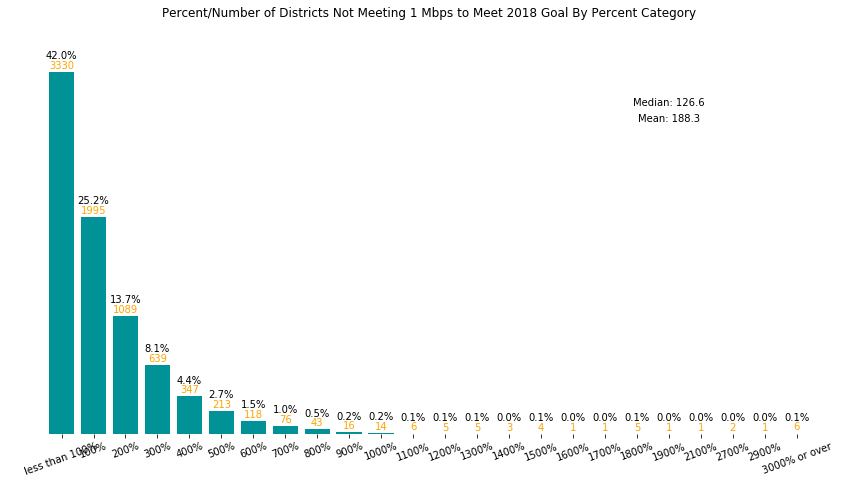

In [34]:
# plotting the figure
plt.figure(figsize=(15, 7))
xmarks = np.arange(0, df_pct_change.shape[0])
plt.bar(xmarks, df_pct_change['district_count'], color='#009296')

# ticks, titles, axis labels
plt.title("Percent/Number of Districts Not Meeting 1 Mbps to Meet 2018 Goal By Percent Category", y=1.08)
plt.xticks(xmarks, df_pct_change.pct_category.values, rotation=20)
plt.box(on=None)
plt.yticks([])

# add sum labels
for x0, v0, label, pct_label in zip(xmarks, 
                         df_pct_change['district_count'], 
                         df_pct_change['district_count'],
                         df_pct_change['district_count_pct']
                        ):
    plt.text(x0, v0+10, round(label), ha='center', va='bottom', color='orange')
    plt.text(x0, v0+100, str(round(pct_label*100, 1))+'%', ha='center', va='bottom')
    
plt.text(19, 3000, "Median: "+str(round(df_clean.pct_bw_increase_to_meet_1Mbps.median(), 1)), ha='center', va='bottom')
plt.text(19, 2850, "Mean: "+str(round(df_clean.pct_bw_increase_to_meet_1Mbps.mean(), 1)), ha='center', va='bottom');

# save
plt.savefig("pct_bw_increase_districts_not_meeting_073119.png", bbox_inches = 'tight')
